In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.ops import MLP
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100, CIFAR10, MNIST
from torch.optim import SGD, lr_scheduler
import copy
from tqdm import tqdm
from collections import OrderedDict
import random
import math
import matplotlib.pyplot as plt

## Data

In [2]:
preprocess = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = CIFAR100('datasets/cifar100', train=True, transform=preprocess, download=True)
test_dataset = CIFAR100('datasets/cifar100', train=False, transform=preprocess, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class LeNet5_circa(nn.Module):
    def __init__(self):
        super( LeNet5_circa, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(576, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool(self.conv1(x).relu())
        x = self.pool(self.conv2(x).relu())
        x = torch.flatten(x, 1)
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        x = nn.functional.softmax(x)
        return x


model = LeNet5_circa().cuda()
model.to('cuda')

criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 0.1)

In [4]:
model

LeNet5_circa(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=100, bias=True)
)

## Training

In [8]:
T = 200
test_freq = 10

In [6]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f} Acc: {test_accuracy:.2f}%')
    return test_accuracy, test_loss


def train(model):
    accuracies = []
    losses = []
    for t in tqdm(range(T)):
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

        if t % test_freq == 0 or t == T-1:
            acc, loss = test(model)
            accuracies.append(acc)
            losses.append(loss)


    return accuracies, losses


accuracies, losses = train(model)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-3-988018075162>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)
  1%|          | 1/100 [00:28<47:09, 28.58s/it]

Test Loss: 4.605164 Acc: 1.00%


 11%|█         | 11/100 [03:43<30:01, 20.24s/it]

Test Loss: 4.604351 Acc: 1.80%


 21%|██        | 21/100 [06:59<26:24, 20.06s/it]

Test Loss: 4.560096 Acc: 6.10%


 31%|███       | 31/100 [10:09<22:39, 19.70s/it]

Test Loss: 4.541631 Acc: 8.02%


 41%|████      | 41/100 [13:21<19:41, 20.03s/it]

Test Loss: 4.529986 Acc: 9.09%


 51%|█████     | 51/100 [16:35<16:24, 20.10s/it]

Test Loss: 4.521160 Acc: 9.89%


 61%|██████    | 61/100 [19:46<12:56, 19.90s/it]

Test Loss: 4.512869 Acc: 10.69%


 71%|███████   | 71/100 [23:06<09:58, 20.62s/it]

Test Loss: 4.514142 Acc: 10.55%


 81%|████████  | 81/100 [26:37<06:43, 21.22s/it]

Test Loss: 4.505318 Acc: 11.54%


 91%|█████████ | 91/100 [30:01<03:10, 21.22s/it]

Test Loss: 4.499867 Acc: 12.05%


100%|██████████| 100/100 [32:59<00:00, 19.79s/it]

Test Loss: 4.493588 Acc: 12.89%


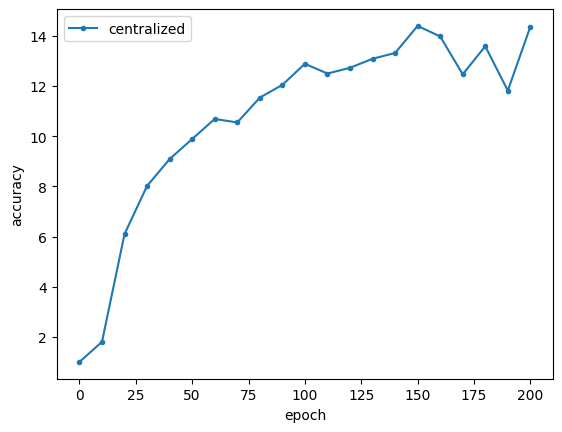

In [20]:
plt.xlabel('epoch')
plt.ylabel('accuracy')
xx = np.arange(0, 4 * T + test_freq, test_freq)
plt.plot(xx, accuracies, label='centralized', marker='.')
plt.legend()